In [1]:
import pandas as pd
import numpy as np
import re
import json
from pandas import json_normalize
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import os
from sklearn.model_selection import train_test_split
#from sklearn.model_selection import GridSearchCV
#from sklearn.neighbors import KNeighborsClassifier
#from sklearn.ensemble import VotingClassifier, RandomForestClassifier
#from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [2]:
def data_preprocessing(path,tag,X_lower_limit,X_upper_limit,Y_lower_limit,Y_upper_limit):
    X_upper_limit=float(X_upper_limit)
    X_lower_limit=float(X_lower_limit)
    Y_upper_limit=float(Y_upper_limit)
    Y_lower_limit=float(Y_lower_limit)
    with open(path,'r') as handle:
        text_data = handle.read()

        text_data = '[' + re.sub(r'\}\s\{','},{', text_data) + ']'
        json_data = json.loads(text_data)
    df_json = pd.DataFrame(json_data)
    for i in range(len(df_json.ObjectList.index)):
        for j in df_json['ObjectList'][i]:
            j['Frame'] = i
    df_json.to_json('temp.json',orient = 'records')
    with open('temp.json') as file:
        data = file.read()
        jsondata = json.loads(data)
    df_json = json_normalize(jsondata, 'ObjectList')
    df_json=pd.DataFrame(df_json)
    df_json = df_json[df_json.rangeIdx != 127]
    df_json.reset_index(drop=True,inplace = True)
    df_json['ObjType']='unknown'
    df_json['Objval']=0

    if tag=='human':
        for i in range(df_json.shape[0]):
            if (df_json['dpplIdx'][i] == 2)|(df_json['dpplIdx'][i] == 3) | (df_json['dpplIdx'][i] == 61) | (df_json['dpplIdx'][i] == 62) and (df_json['Coordinates.X'][i] >=X_lower_limit) and (df_json['Coordinates.X'][i] <=X_upper_limit) and (df_json['Coordinates.Y'][i] >= Y_lower_limit) and (df_json['Coordinates.Y'][i] <= Y_upper_limit):
                df_json['ObjType'][i]='human'
                df_json['Objval'][i]=1
    elif tag=='carV':
        for i in range(df_json.shape[0]):
            if df_json['dpplIdx'][i] == 0 and (df_json['Coordinates.Y'][i] >= Y_lower_limit) and (df_json['Coordinates.Y'][i] <= Y_upper_limit):
                df_json['ObjType'][i]='car_ver'
                df_json['Objval'][i]=2
    elif tag=='carH':
        for i in range(df_json.shape[0]):
            if df_json['dpplIdx'][i] == 0:
                df_json['ObjType'][i]='car_hor'
                df_json['Objval'][i]=3
    else:
        print("No tag found.!!")
    #print(df_json[df_json['ObjType']=='human'])
    return df_json

In [3]:
def peak_values(df_merged):
    df_merged[['pk1','pk2','pk3','pk4','pk5']] = pd.DataFrame(df_merged.pkArray.values.tolist(), index= df_merged.index)
    df = pd.DataFrame()
    df[['Objval','ObjType','dpplIdx','Frame','pk1','pk2','pk3','pk4','pk5','Range','Coordinates.X','Coordinates.Y']] = df_merged[['Objval','ObjType','dpplIdx','Frame','pk1','pk2','pk3','pk4','pk5','Range','Coordinates.X','Coordinates.Y']]
    df[['X1_1','X1_2','X1_3','X1_4','X1_5','X1_6','X1_7']]=pd.DataFrame(df.pk1.values.tolist(), index= df.index)
    df[['X2_1','X2_2','X2_3','X2_4','X2_5','X2_6','X2_7']]=pd.DataFrame(df.pk2.values.tolist(), index= df.index)
    df[['X3_1','X3_2','X3_3','X3_4','X3_5','X3_6','X3_7']]=pd.DataFrame(df.pk3.values.tolist(), index= df.index)
    df[['X4_1','X4_2','X4_3','X4_4','X4_5','X4_6','X4_7']]=pd.DataFrame(df.pk4.values.tolist(), index= df.index)
    df[['X5_1','X5_2','X5_3','X5_4','X5_5','X5_6','X5_7']]=pd.DataFrame(df.pk5.values.tolist(), index= df.index)
    df=df.drop(['pk1', 'pk2','pk3','pk4','pk5'], axis=1)
    return df


In [4]:
def range_pow(df):
    df['Range_Power']=pow(df['Range'],2)*(df['X3_4'])
    df['Range_Power_3']=pow(df['Range'],3)*(df['X3_4'])
    return df

In [5]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [6]:
folders=os.listdir('filesUsedForTraining/')
df_merged=pd.DataFrame()
print(folders)
for f in folders:
    if f=='carH':
        for i in os.listdir('filesUsedForTraining/'+str(f)+'/'):
            r=str(i).split('_')[1]
            path='filesUsedForTraining/'+str(f)+'/'+str(i)
            x_lower=int(r)-0.5
            x_upper=int(r)+0.5
            print('filesUsedForTraining/'+str(f)+'/'+str(i))
            df_merged=df_merged.append(data_preprocessing(path,str(f),x_lower,x_upper,0,0))
        df_merged.reset_index(drop=True,inplace = True)
    elif f=='carV':
        for i in os.listdir('filesUsedForTraining/'+str(f)+'/'):
            print('filesUsedForTraining/'+str(f)+'/'+str(i))
            r=str(i).split('_')[1]
            path='filesUsedForTraining/'+str(f)+'/'+str(i)
            y_lower=int(r)-0.5
            y_upper=int(r)+0.5
            df_merged=df_merged.append(data_preprocessing(path,str(f),0,0,y_lower,y_upper))
        df_merged.reset_index(drop=True,inplace = True)
    elif f=='human':
        for i in os.listdir('filesUsedForTraining/'+str(f)+'/'):
            print('filesUsedForTraining/'+str(f)+'/'+str(i))
            r=str(i).split('_')[1]
            path='filesUsedForTraining/'+str(f)+'/'+str(i)
            y_lower=int(str(r).split('-')[0])-1
            y_upper=int(str(str(r).split('-')[1])[0])+1
            print(y_lower,y_upper)
            df_merged=df_merged.append(data_preprocessing(path,str(f),-0.5,0.5,y_lower,y_upper))
        df_merged.reset_index(drop=True,inplace = True)

    else:
        print('No folder available')

['carH', 'carV', 'human']
filesUsedForTraining/carH/Car Horizontal_11_27_01_2020 13_40_38.json


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:40: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



filesUsedForTraining/carH/Car Horizontal_12_27_01_2020 13_42_06.json


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:40: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



filesUsedForTraining/carH/Car Horizontal_13_27_01_2020 13_44_51.json


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:40: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



filesUsedForTraining/carH/Car Horizontal_14_27_01_2020 13_51_13.json


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:40: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



filesUsedForTraining/carH/Car Horizontal_15_27_01_2020 13_15_54.json


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:40: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



filesUsedForTraining/carH/Car Horizontal_16_27_01_2020 13_16_51.json


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:40: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



filesUsedForTraining/carH/Car Horizontal_17_27_01_2020 13_17_50.json


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:40: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



filesUsedForTraining/carH/Car Horizontal_18_27_01_2020 13_18_50.json


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:40: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



filesUsedForTraining/carH/Car Horizontal_20_27_01_2020 13_21_11.json


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:40: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



filesUsedForTraining/carH/Car Horizontal_5_27_01_2020 13_05_27.json


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:40: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



filesUsedForTraining/carH/Car Horizontal_7_27_01_2020 13_07_36.json


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:40: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



filesUsedForTraining/carV/Car Vertical_10_27_01_2020 12_46_59.json
filesUsedForTraining/carV/Car Vertical_13_27_01_2020 12_50_12.json
filesUsedForTraining/carV/Car Vertical_15_27_01_2020 12_52_44.json
filesUsedForTraining/carV/Car Vertical_16_27_01_2020 12_53_52.json
filesUsedForTraining/carV/Car Vertical_18_27_01_2020 12_56_36.json
filesUsedForTraining/carV/Car Vertical_19_27_01_2020 12_57_35.json
filesUsedForTraining/carV/Car Vertical_2_27_01_2020 12_38_30.json


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



filesUsedForTraining/carV/Car Vertical_4_27_01_2020 12_40_36.json
filesUsedForTraining/carV/Car Vertical_6_27_01_2020 12_42_51.json
filesUsedForTraining/carV/Car Vertical_8_27_01_2020 12_44_58.json
filesUsedForTraining/human/Human_1-5m_16_05_2020 18_12_41.json
0 6


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



filesUsedForTraining/human/Human_1-5m_18_05_2020 16_28_18.json
0 6


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



filesUsedForTraining/human/Human_1-7 m_16_05_2020 18_14_53.json
0 8


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



filesUsedForTraining/human/Human_1-7m _18_05_2020 16_30_50.json
0 8


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [7]:
df=peak_values(df_merged)

In [8]:
df[df['ObjType']=='car_hor']

,Objval,ObjType,dpplIdx,Frame,Range,Coordinates.X,Coordinates.Y,X1_1,X1_2,X1_3,...,X4_5,X4_6,X4_7,X5_1,X5_2,X5_3,X5_4,X5_5,X5_6,X5_7
0,3,car_hor,0,0,10.828125,-10.828125,6.630095e-16,0.0,0.0,290.826416,...,0.0,0.0,2354.872800,1196.050540,3.162278,0.0,0.0,323.055725,163.917664,8.944272
1,3,car_hor,0,0,22.148438,-22.148438,0.000000e+00,0.0,0.0,7.071068,...,0.0,0.0,41.036568,24.758837,6.324555,0.0,0.0,7.000000,7.615773,7.810250
7,3,car_hor,0,1,10.828125,-10.828125,6.630095e-16,0.0,0.0,292.605530,...,0.0,0.0,2368.603000,1220.639160,25.079872,0.0,0.0,376.629800,190.515091,8.246211
8,3,car_hor,0,1,22.148438,-22.134945,7.729693e-01,0.0,0.0,4.242641,...,0.0,0.0,55.000000,22.847319,12.649111,0.0,0.0,13.038405,7.280110,14.422205
9,3,car_hor,0,1,31.992188,-31.992188,0.000000e+00,0.0,0.0,26.000000,...,0.0,0.0,38.897300,24.698177,6.708204,0.0,0.0,23.086792,18.439089,18.439089
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24150,3,car_hor,0,323,14.765625,-14.756630,5.153129e-01,0.0,0.0,47.927030,...,0.0,0.0,89.888820,50.159744,6.708204,0.0,0.0,19.235384,7.615773,10.816654
24151,3,car_hor,0,323,21.656250,-21.656250,0.000000e+00,0.0,0.0,17.492855,...,0.0,0.0,52.952810,28.284271,4.242641,0.0,0.0,30.066593,16.278820,9.486833
24156,3,car_hor,0,324,0.000000,0.000000,0.000000e+00,0.0,0.0,0.000000,...,0.0,0.0,751.732000,385.406281,4.123106,0.0,0.0,379.612946,192.208221,2.000000
24157,3,car_hor,0,324,6.890625,-6.886427,2.404793e-01,0.0,0.0,152.486069,...,0.0,0.0,4224.262700,2163.451000,18.248287,0.0,0.0,1731.989870,877.090637,9.848858


In [9]:
df[df['ObjType']=='car_ver']

,Objval,ObjType,dpplIdx,Frame,Range,Coordinates.X,Coordinates.Y,X1_1,X1_2,X1_3,...,X4_5,X4_6,X4_7,X5_1,X5_2,X5_3,X5_4,X5_5,X5_6,X5_7
37637,2,car_ver,0,0,2.460938,1.304098,2.086993,0.0,0.0,899.387600,...,0.0,0.0,976.901733,502.937378,10.000000,0.0,0.0,1436.57263,737.360168,8.062258
37645,2,car_ver,0,1,1.968750,1.100911,1.632168,0.0,0.0,787.383667,...,0.0,0.0,819.274048,417.929400,3.162278,0.0,0.0,1002.10278,512.285100,2.828427
37651,2,car_ver,0,2,2.460938,1.304098,2.086993,0.0,0.0,898.519348,...,0.0,0.0,916.100952,467.184100,10.000000,0.0,0.0,1311.58411,672.170349,11.180340
37658,2,car_ver,0,3,1.968750,1.100911,1.632168,0.0,0.0,788.609558,...,0.0,0.0,1092.943240,557.943542,4.000000,0.0,0.0,1020.20100,526.745667,6.324555
37666,2,car_ver,0,4,2.460938,1.304098,2.086993,0.0,0.0,904.358900,...,0.0,0.0,960.402500,492.354553,12.206555,0.0,0.0,1385.77417,713.361755,12.165525
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39965,2,car_ver,0,309,1.968750,1.100911,1.632168,0.0,0.0,791.432251,...,0.0,0.0,779.092400,406.995100,6.403124,0.0,0.0,1070.91406,551.841500,10.295630
39973,2,car_ver,0,310,1.968750,1.100911,1.632168,0.0,0.0,789.270569,...,0.0,0.0,732.789200,371.323300,6.082763,0.0,0.0,1007.00200,522.422241,12.165525
39981,2,car_ver,0,311,2.460938,1.304098,2.086993,0.0,0.0,915.756531,...,0.0,0.0,1037.501340,539.179000,15.297058,0.0,0.0,1515.46985,780.287100,13.601471
39989,2,car_ver,0,312,1.968750,1.100911,1.632168,0.0,0.0,784.467346,...,0.0,0.0,637.095000,320.731964,2.000000,0.0,0.0,1049.65234,541.003700,10.440307


In [10]:
df[df['ObjType']=='human']

,Objval,ObjType,dpplIdx,Frame,Range,Coordinates.X,Coordinates.Y,X1_1,X1_2,X1_3,...,X4_5,X4_6,X4_7,X5_1,X5_2,X5_3,X5_4,X5_5,X5_6,X5_7
46133,1,human,2,32,0.492188,-0.091745,0.483561,0.000000,0.000000,0.000000,...,267.166626,83.815270,51.351726,8.485281,1.000000,209.847565,137.277100,24.351591,3.162278,2.236068
46141,1,human,2,33,0.492188,-0.061363,0.488347,0.000000,0.000000,0.000000,...,441.814453,402.851074,139.014389,2.236068,1.414214,190.394333,110.421921,15.556349,6.324555,2.236068
46147,1,human,2,34,0.492188,0.000000,0.492188,0.000000,0.000000,0.000000,...,262.922028,129.313568,28.600699,21.470911,1.414214,204.298800,114.769333,22.203604,10.198039,2.000000
46148,1,human,3,34,0.984375,-0.122727,0.976695,0.000000,0.000000,0.000000,...,114.769333,22.203604,10.198039,2.000000,3.000000,52.038450,18.248287,2.236068,2.236068,5.656854
46155,1,human,2,35,0.984375,0.030757,0.983894,0.000000,0.000000,0.000000,...,264.690400,187.446000,40.000000,14.866069,4.472136,90.443350,40.311287,23.706540,9.486833,4.242641
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76750,1,human,3,995,4.921875,0.153784,4.919472,33.421550,21.840330,13.601471,...,403.792023,17.088007,27.459060,16.278820,5.830952,542.943848,5.385165,12.000000,8.544003,10.816654
76758,1,human,2,996,4.921875,0.153784,4.919472,39.051247,20.615528,19.849434,...,720.958400,348.885376,61.351448,11.180340,10.630146,998.685600,501.399048,11.180340,5.385165,12.806249
76759,1,human,3,996,4.921875,0.153784,4.919472,20.615528,19.849434,7.000000,...,348.885376,61.351448,11.180340,10.630146,8.602325,501.399048,11.180340,5.385165,12.806249,13.928389
76765,1,human,2,997,4.921875,0.307417,4.912265,49.477270,28.653097,4.242641,...,750.094666,293.170600,99.904950,21.023796,9.433981,1032.361330,494.910100,34.713108,5.000000,7.071068


In [11]:
# shuffle the DataFrame rows 
df = df.sample(frac = 1) 
df

,Objval,ObjType,dpplIdx,Frame,Range,Coordinates.X,Coordinates.Y,X1_1,X1_2,X1_3,...,X4_5,X4_6,X4_7,X5_1,X5_2,X5_3,X5_4,X5_5,X5_6,X5_7
50226,0,unknown,1,560,9.843750,6.709882,7.202562,0.000000,995.827800,504.525500,...,0.000000,1095.851320,561.587036,8.602325,13.601471,0.000000,1232.065000,637.003100,13.038405,10.000000
10146,0,unknown,63,82,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.414214,4.000000,321.398500,0.000000,0.000000,2.236068,1.414214,142.688477,0.000000,0.000000
70569,0,unknown,1,200,9.843750,6.481562,7.408695,0.000000,886.084656,457.517200,...,0.000000,1429.209590,748.128357,20.615528,5.656854,0.000000,686.942500,364.627200,13.152947,1.000000
29804,0,unknown,0,97,62.015625,-12.893773,60.660435,0.000000,0.000000,250.697021,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
68328,0,unknown,0,906,9.843750,6.709882,7.202562,0.000000,0.000000,690.684448,...,0.000000,0.000000,1846.963500,940.740100,6.403124,0.000000,0.000000,2299.614000,1177.066280,8.944272
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44010,0,unknown,1,67,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,637.028259,326.553223,4.123106,1.414214,0.000000,296.588928,152.977127,2.828427,2.000000
36085,0,unknown,1,69,19.195312,10.733883,15.913635,0.000000,25.079872,20.615528,...,0.000000,176.232800,93.230896,9.486833,9.219544,0.000000,118.207443,59.211487,2.236068,3.605551
42954,0,unknown,6,222,5.906250,-1.627983,5.677452,8.062258,5.000000,7.071068,...,10.816654,7.071068,5.830952,1.414214,3.605551,13.453624,17.492855,12.529964,1.000000,2.236068
4408,0,unknown,51,121,5.906250,-1.227978,5.777184,9.055386,9.219544,8.485281,...,9.486833,6.708204,1.000000,12.041595,14.764823,5.656854,7.071068,5.830952,2.236068,9.055386


In [12]:
df=range_pow(df)
df_new=df[df['ObjType']!='unknown']

In [13]:
df_new

,Objval,ObjType,dpplIdx,Frame,Range,Coordinates.X,Coordinates.Y,X1_1,X1_2,X1_3,...,X4_7,X5_1,X5_2,X5_3,X5_4,X5_5,X5_6,X5_7,Range_Power,Range_Power_3
6244,3,car_hor,0,248,14.273438,7.981605,11.833216,0.000000,0.000000,44.643030,...,291.358900,155.563492,15.297058,0.000000,0.00000,120.486511,60.415230,12.206555,329352.478558,4.700992e+06
3151,3,car_hor,0,170,12.304688,6.152344,10.656172,0.000000,0.000000,228.078934,...,258.071700,123.016258,13.892444,0.000000,0.00000,134.406100,68.447060,12.649111,378111.719905,4.652547e+06
67045,1,human,3,745,1.968750,0.366981,1.934244,138.755173,24.083189,5.656854,...,19.849434,6.082763,1.000000,35.057095,20.00000,9.219544,5.000000,2.236068,1322.577289,2.603824e+03
14775,3,car_hor,0,173,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,746.295532,383.099200,4.000000,0.000000,0.00000,365.859253,187.299225,1.000000,0.000000,0.000000e+00
38454,2,car_ver,0,109,1.968750,1.100911,1.632168,0.000000,0.000000,788.700800,...,802.419500,412.080078,8.944272,0.000000,0.00000,924.082300,476.186951,8.246211,15836.623954,3.117835e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8856,3,car_hor,0,266,16.242188,8.121094,14.066147,0.000000,0.000000,45.705578,...,420.023800,216.178162,2.000000,0.000000,0.00000,92.962360,51.312767,5.830952,392227.048909,6.370625e+06
15097,3,car_hor,0,228,19.687500,7.375067,18.253932,0.000000,0.000000,13.000000,...,305.080322,148.084442,6.082763,0.000000,0.00000,137.528183,62.968246,4.472136,296370.307529,5.834790e+06
48558,1,human,2,344,4.921875,0.153784,4.919472,91.137260,47.169907,2.236068,...,48.764740,5.099020,6.403124,1026.712280,529.68860,8.062258,7.071068,12.083046,11063.731904,5.445431e+04
59856,1,human,2,832,2.460938,0.230375,2.450131,392.042084,197.881271,5.385165,...,50.960770,5.385165,2.000000,139.201300,71.11962,4.123106,11.704700,2.236068,3457.907069,8.509693e+03


In [14]:
df_new[df_new['Objval']==3]

,Objval,ObjType,dpplIdx,Frame,Range,Coordinates.X,Coordinates.Y,X1_1,X1_2,X1_3,...,X4_7,X5_1,X5_2,X5_3,X5_4,X5_5,X5_6,X5_7,Range_Power,Range_Power_3
6244,3,car_hor,0,248,14.273438,7.981605,1.183322e+01,0.0,0.0,44.643030,...,291.358900,155.563492,15.297058,0.0,0.0,120.486511,60.415230,12.206555,329352.478558,4.700992e+06
3151,3,car_hor,0,170,12.304688,6.152344,1.065617e+01,0.0,0.0,228.078934,...,258.071700,123.016258,13.892444,0.0,0.0,134.406100,68.447060,12.649111,378111.719905,4.652547e+06
14775,3,car_hor,0,173,0.000000,0.000000,0.000000e+00,0.0,0.0,0.000000,...,746.295532,383.099200,4.000000,0.0,0.0,365.859253,187.299225,1.000000,0.000000,0.000000e+00
23374,3,car_hor,0,226,14.765625,-14.765625,9.041039e-16,0.0,0.0,17.720045,...,99.478640,48.259712,3.605551,0.0,0.0,46.097720,25.079872,9.486833,67397.535342,9.951667e+05
891,3,car_hor,0,141,10.828125,-10.828125,6.630095e-16,0.0,0.0,294.871155,...,2567.848390,1325.271730,26.925823,0.0,0.0,451.807500,229.582230,7.071068,886502.369043,9.599158e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3908,3,car_hor,0,318,12.304688,6.152344,1.065617e+01,0.0,0.0,217.082932,...,241.679535,131.825638,10.630146,0.0,0.0,32.557640,15.033297,4.472136,385578.154365,4.744419e+06
24140,3,car_hor,0,322,0.000000,0.000000,0.000000e+00,0.0,0.0,0.000000,...,765.755200,392.842200,5.099020,0.0,0.0,366.565125,188.281708,2.828427,0.000000,0.000000e+00
8856,3,car_hor,0,266,16.242188,8.121094,1.406615e+01,0.0,0.0,45.705578,...,420.023800,216.178162,2.000000,0.0,0.0,92.962360,51.312767,5.830952,392227.048909,6.370625e+06
15097,3,car_hor,0,228,19.687500,7.375067,1.825393e+01,0.0,0.0,13.000000,...,305.080322,148.084442,6.082763,0.0,0.0,137.528183,62.968246,4.472136,296370.307529,5.834790e+06


# Analysis considering 17th Peak Array

In [16]:
#dfclassify=df.iloc[:, df.columns != 'ObjType']
#dfclassify=dfclassify.iloc[:, dfclassify.columns != 'Objval']
#dfclassify=dfclassify.iloc[:, dfclassify.columns != 'Frame']
dfclassify=df_new[['dpplIdx', 'Range', 'Coordinates.X', 'Coordinates.Y','X3_4']]
dfy=df_new['ObjType']
dfz=df_new['Objval']
print(dfclassify.shape)
print(dfy.shape)

(13305, 5)
(13305,)


In [17]:
X = dfclassify.values
Y = dfz.values

In [18]:
X_train,X_val,y_train,y_val=train_test_split(X, Y, test_size=0.3, stratify=Y)

In [19]:
dfclassify.columns

Index(['dpplIdx', 'Range', 'Coordinates.X', 'Coordinates.Y', 'X3_4'], dtype='object')

In [20]:
knn = KNeighborsClassifier()
#create a dictionary of all values we want to test for n_neighbors
params_knn = {'n_neighbors': np.arange(1, 25)}
#use gridsearch to test all values for n_neighbors
knn_gs = GridSearchCV(knn, params_knn, cv=5)
#fit model to training data
knn_gs.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24])})

In [21]:
knn_best = knn_gs.best_estimator_
#check best n_neigbors value
print(knn_gs.best_params_)

{'n_neighbors': 1}


In [22]:
print('knn: {}'.format(knn_best.score(X_val, y_val)))

knn: 0.9947394789579158


In [23]:
#create a new rf classifier
rf = RandomForestClassifier()

#create a dictionary of all values we want to test for n_estimators
params_rf = {'n_estimators': [50, 100, 200]}

#use gridsearch to test all values for n_estimators
rf_gs = GridSearchCV(rf, params_rf, cv=5)

#fit model to training data
rf_gs.fit(X_train, y_train)
rf_best = rf_gs.best_estimator_

#check best n_estimators value
print(rf_gs.best_params_)

{'n_estimators': 50}


In [24]:
print('rf: {}'.format(rf_best.score(X_val, y_val)))

rf: 1.0


In [25]:
#create a new logistic regression model
log_reg = LogisticRegression()
#fit the model to the training data
log_reg.fit(X_train, y_train)
#test the three models with the test data and print their accuracy scores
print('log_reg: {}'.format(log_reg.score(X_val, y_val)))

log_reg: 0.9769539078156313


C:\Users\monik\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



C:\Users\monik\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Confusion Matrix :
[[1528    0    0]
 [   0   87    5]
 [   0    0 2372]]
Accuracy Score : 0.99874749498998
Report : 
              precision    recall  f1-score   support

           1       1.00      1.00      1.00      1528
           2       1.00      0.95      0.97        92
           3       1.00      1.00      1.00      2372

    accuracy                           1.00      3992
   macro avg       1.00      0.98      0.99      3992
weighted avg       1.00      1.00      1.00      3992

Confusion matrix, without normalization
[[1528    0    0]
 [   0   87    5]
 [   0    0 2372]]


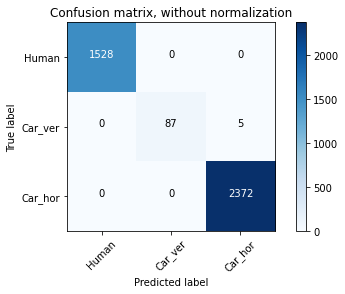

In [26]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
#create a dictionary of our models
estimators=[('knn', knn_best), ('rf', rf_best), ('log_reg', log_reg)]

#create our voting classifier, inputting our models
ensemble = VotingClassifier(estimators, voting='hard')

#fit model to training data
ensemble.fit(X_train, y_train)
pred=ensemble.predict(X_val)
#test our model on the test data
test=ensemble.score(X_val, y_val)
confusion = confusion_matrix(y_val, pred) 
print ('Confusion Matrix :')
print(confusion) 
print ('Accuracy Score :',accuracy_score(y_val, pred))
print ('Report : ')
print (classification_report(y_val, pred))
class_names=['Human','Car_ver','Car_hor']
plt.figure()
plot_confusion_matrix(confusion, classes=class_names,
                      title='Confusion matrix, without normalization')


plt.show()

In [27]:
folders=os.listdir('filesUsedForTesting/')
dfTest_merged=pd.DataFrame()
print(folders)
for f in folders:
    if f=='carH':
        for i in os.listdir('filesUsedForTesting/'+str(f)+'/'):
            r=str(i).split('_')[1]
            path='filesUsedForTesting/'+str(f)+'/'+str(i)
            x_lower=int(r)-0.5
            x_upper=int(r)+0.5
            print('filesUsedForTesting/'+str(f)+'/'+str(i))
            dfTest_merged=dfTest_merged.append(data_preprocessing(path,str(f),x_lower,x_upper,0,0))
        dfTest_merged.reset_index(drop=True,inplace = True)
    elif f=='carV':
        for i in os.listdir('filesUsedForTesting/'+str(f)+'/'):
            print('filesUsedForTesting/'+str(f)+'/'+str(i))
            r=str(i).split('_')[1]
            path='filesUsedForTesting/'+str(f)+'/'+str(i)
            y_lower=int(r)-0.5
            y_upper=int(r)+0.5
            dfTest_merged=dfTest_merged.append(data_preprocessing(path,str(f),0,0,y_lower,y_upper))
        dfTest_merged.reset_index(drop=True,inplace = True)
    elif f=='human':
        for i in os.listdir('filesUsedForTesting/'+str(f)+'/'):
            print('filesUsedForTesting/'+str(f)+'/'+str(i))
            r=str(i).split('_')[1]
            path='filesUsedForTesting/'+str(f)+'/'+str(i)
            y_lower=int(str(r).split('-')[0])-1
            y_upper=int(str(str(r).split('-')[1])[0])+1
            print(y_lower,y_upper)
            dfTest_merged=dfTest_merged.append(data_preprocessing(path,str(f),-0.5,0.5,y_lower,y_upper))
        dfTest_merged.reset_index(drop=True,inplace = True)
    else:
        print('No folder available')

['carH', 'carV', 'human']
filesUsedForTesting/carH/Car Horizontal_2_12_03_2020 14_50_24.json


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:40: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



filesUsedForTesting/carH/Car Horizontal_4_12_03_2020 14_53_38.json


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:40: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



filesUsedForTesting/carH/Car Horizontal_6_12_03_2020 15_00_25.json


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:40: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



filesUsedForTesting/carV/Car Vertical_15_28_02_2020 13_23_56.json


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



filesUsedForTesting/carV/Car Vertical_5_28_02_2020 12_38_17.json


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



filesUsedForTesting/human/Human_1-5m moving_15_05_2020 18_37_03.json
0 6


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



filesUsedForTesting/human/Human_1-7m moving_15_05_2020 18_39_36.json
0 8


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [28]:
df_Test=peak_values(dfTest_merged)
df_Test = df_Test.sample(frac = 1) 
df_Test=range_pow(df_Test)
df_Test_new=df_Test[df_Test['ObjType']!='unknown']

In [29]:
df_Test_new[df_Test_new['Objval']==3]

,Objval,ObjType,dpplIdx,Frame,Range,Coordinates.X,Coordinates.Y,X1_1,X1_2,X1_3,...,X4_7,X5_1,X5_2,X5_3,X5_4,X5_5,X5_6,X5_7,Range_Power,Range_Power_3
2747,3,car_hor,0,459,4.429688,0.276675,4.421039,0.0,0.0,784.461600,...,701.923767,367.196136,1.000000,0.0,0.0,438.426727,229.427551,4.000000,23203.150696,102782.706601
2195,3,car_hor,0,366,1.968750,-0.061513,1.967789,0.0,0.0,313.408700,...,806.595337,416.146600,10.049875,0.0,0.0,1807.303000,932.695557,18.681541,19809.585202,39000.120867
8663,3,car_hor,0,728,3.937500,0.368600,3.920209,0.0,0.0,279.732025,...,949.068000,484.660700,7.211102,0.0,0.0,547.477844,288.189178,15.264337,42176.578500,166070.277844
799,3,car_hor,0,124,4.429688,0.414675,4.410235,0.0,0.0,832.009644,...,191.880173,102.044106,6.082763,0.0,0.0,10.440307,2.828427,0.000000,18287.089860,81006.093365
4221,3,car_hor,0,700,5.414062,1.009199,5.319172,0.0,0.0,1415.207760,...,386.544952,194.329620,5.000000,0.0,0.0,146.277130,81.154175,2.828427,40133.708958,217286.408654
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3407,3,car_hor,0,564,1.968750,0.000000,1.968750,0.0,0.0,309.413971,...,698.011500,360.080536,6.403124,0.0,0.0,1771.433840,911.930359,12.165525,19949.223653,39275.034067
8450,3,car_hor,0,682,3.937500,0.245934,3.929812,0.0,0.0,284.255157,...,942.015400,487.447418,7.211102,0.0,0.0,558.616150,291.650482,8.062258,42050.310812,165573.098820
13074,3,car_hor,0,723,5.906250,0.368900,5.894718,0.0,0.0,469.623260,...,196.499359,111.198021,16.278820,0.0,0.0,328.896637,162.262131,11.313708,91526.137134,540576.247446
7696,3,car_hor,0,522,3.937500,0.368600,3.920209,0.0,0.0,281.016022,...,973.359131,500.185974,11.661903,0.0,0.0,540.712463,285.280579,11.045361,42412.749504,167000.201172


In [32]:
dfclassify_Test=df_Test_new[['dpplIdx', 'Range', 'Coordinates.X', 'Coordinates.Y','X3_4']]
dfy_Test=df_Test_new['ObjType']
dfz_Test=df_Test_new['Objval']
print(dfclassify_Test.shape)
print(dfy_Test.shape)


(7788, 5)
(7788,)


In [33]:
X_test = dfclassify_Test.values
y_test = dfz_Test.values

In [34]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print('knn: {}'.format(knn_best.score(X_test, y_test)))
pred=knn_best.predict(X_test)
confusion_matrix = confusion_matrix(y_test,pred)
print("Confusion Matrix:")
print(confusion_matrix)
classification_report = classification_report(y_test,pred)
print("Classification Report:")
print(classification_report)
accuracy = accuracy_score(y_test,pred)
print("Accuracy:",accuracy)

knn: 0.6230097586029789
Confusion Matrix:
[[2092    0    5]
 [ 514    0 1485]
 [ 677  255 2760]]
Classification Report:
              precision    recall  f1-score   support

           1       0.64      1.00      0.78      2097
           2       0.00      0.00      0.00      1999
           3       0.65      0.75      0.70      3692

    accuracy                           0.62      7788
   macro avg       0.43      0.58      0.49      7788
weighted avg       0.48      0.62      0.54      7788

Accuracy: 0.6230097586029789


In [36]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print('rf: {}'.format(rf_best.score(X_test, y_test)))
pred=rf_best.predict(X_test)
confusion_matrix = confusion_matrix(y_test,pred)
print("Confusion Matrix:")
print(confusion_matrix)
classification_report = classification_report(y_test,pred)
print("Classification Report:")
print(classification_report)
accuracy = accuracy_score(y_test,pred)
print("Accuracy:",accuracy)

rf: 0.628145865434001
Confusion Matrix:
[[2097    0    0]
 [   0    0 1999]
 [   0  897 2795]]
Classification Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00      2097
           2       0.00      0.00      0.00      1999
           3       0.58      0.76      0.66      3692

    accuracy                           0.63      7788
   macro avg       0.53      0.59      0.55      7788
weighted avg       0.55      0.63      0.58      7788

Accuracy: 0.628145865434001


In [37]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print('log_reg: {}'.format(log_reg.score(X_test, y_test)))
pred=log_reg.predict(X_test)
confusion_matrix = confusion_matrix(y_test,pred)
print("Confusion Matrix:")
print(confusion_matrix)
classification_report = classification_report(y_test,pred)
print("Classification Report:")
print(classification_report)
accuracy = accuracy_score(y_test,pred)
print("Accuracy:",accuracy)

log_reg: 0.7433230611196713
Confusion Matrix:
[[2097    0    0]
 [   0    0 1999]
 [   0    0 3692]]
Classification Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00      2097
           2       0.00      0.00      0.00      1999
           3       0.65      1.00      0.79      3692

    accuracy                           0.74      7788
   macro avg       0.55      0.67      0.60      7788
weighted avg       0.58      0.74      0.64      7788

Accuracy: 0.7433230611196713


C:\Users\monik\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\monik\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\monik\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Confusion Matrix :
[[2097    0    0]
 [   0    0 1999]
 [   0    0 3692]]
Accuracy Score : 0.7433230611196713
Report : 
              precision    recall  f1-score   support

           1       1.00      1.00      1.00      2097
           2       0.00      0.00      0.00      1999
           3       0.65      1.00      0.79      3692

    accuracy                           0.74      7788
   macro avg       0.55      0.67      0.60      7788
weighted avg       0.58      0.74      0.64      7788

Confusion matrix, without normalization
[[2097    0    0]
 [   0    0 1999]
 [   0    0 3692]]


C:\Users\monik\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\monik\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\monik\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



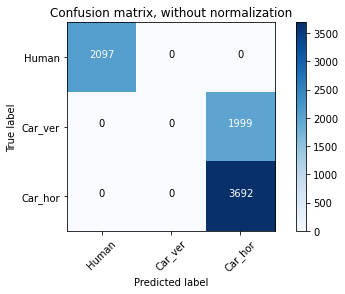

In [38]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
pred=ensemble.predict(X_test)
#test our model on the test data
test=ensemble.score(X_test, y_test)
confusion = confusion_matrix(y_test, pred) 
print ('Confusion Matrix :')
print(confusion) 
print ('Accuracy Score :',accuracy_score(y_test, pred))
print ('Report : ')
print (classification_report(y_test, pred))
class_names=['Human','Car_ver','Car_hor']
plt.figure()
plot_confusion_matrix(confusion, classes=class_names,
                      title='Confusion matrix, without normalization')


plt.show()

# Analysis considering Range Power

In [39]:
#dfclassify=df.iloc[:, df.columns != 'ObjType']
#dfclassify=dfclassify.iloc[:, dfclassify.columns != 'Objval']
#dfclassify=dfclassify.iloc[:, dfclassify.columns != 'Frame']
dfclassify=df_new[['dpplIdx', 'Range', 'Coordinates.X', 'Coordinates.Y','Range_Power']]
dfy=df_new['ObjType']
dfz=df_new['Objval']
print(dfclassify.shape)
print(dfy.shape)

(13305, 5)
(13305,)


In [40]:
X = dfclassify.values
Y = dfz.values

In [41]:
Y

array([3, 3, 1, ..., 1, 1, 3], dtype=int64)

In [42]:
X_train,X_val,y_train,y_val=train_test_split(X, Y, test_size=0.3, stratify=Y)

In [43]:
len(X_train)

9313

In [44]:
len(X_val)

3992

In [45]:
dfclassify.columns

Index(['dpplIdx', 'Range', 'Coordinates.X', 'Coordinates.Y', 'Range_Power'], dtype='object')

In [46]:
knn = KNeighborsClassifier()
#create a dictionary of all values we want to test for n_neighbors
params_knn = {'n_neighbors': np.arange(1, 25)}
#use gridsearch to test all values for n_neighbors
knn_gs = GridSearchCV(knn, params_knn, cv=5)
#fit model to training data
knn_gs.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24])})

In [47]:
#save best model
knn_best = knn_gs.best_estimator_
#check best n_neigbors value
print(knn_gs.best_params_)

{'n_neighbors': 1}


In [48]:
print('knn: {}'.format(knn_best.score(X_val, y_val)))

knn: 0.9882264529058116


In [49]:
#create a new rf classifier
rf = RandomForestClassifier()

#create a dictionary of all values we want to test for n_estimators
params_rf = {'n_estimators': [50, 100, 200]}

#use gridsearch to test all values for n_estimators
rf_gs = GridSearchCV(rf, params_rf, cv=5)

#fit model to training data
rf_gs.fit(X_train, y_train)
rf_best = rf_gs.best_estimator_

#check best n_estimators value
print(rf_gs.best_params_)

{'n_estimators': 50}


In [50]:
print('rf: {}'.format(rf_best.score(X_val, y_val)))

rf: 1.0


In [51]:
#create a new logistic regression model
log_reg = LogisticRegression()
#fit the model to the training data
log_reg.fit(X_train, y_train)
#test the three models with the test data and print their accuracy scores
print('log_reg: {}'.format(log_reg.score(X_val, y_val)))

log_reg: 0.9769539078156313


Confusion Matrix :
[[1528    0    0]
 [  19   71    2]
 [   0    0 2372]]
Accuracy Score : 0.9947394789579158
Report : 
              precision    recall  f1-score   support

           1       0.99      1.00      0.99      1528
           2       1.00      0.77      0.87        92
           3       1.00      1.00      1.00      2372

    accuracy                           0.99      3992
   macro avg       1.00      0.92      0.95      3992
weighted avg       0.99      0.99      0.99      3992

Confusion matrix, without normalization
[[1528    0    0]
 [  19   71    2]
 [   0    0 2372]]


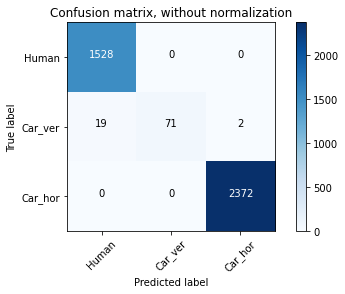

In [52]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
#create a dictionary of our models
estimators=[('knn', knn_best), ('rf', rf_best), ('log_reg', log_reg)]

#create our voting classifier, inputting our models
ensemble = VotingClassifier(estimators, voting='hard')

#fit model to training data
ensemble.fit(X_train, y_train)
pred=ensemble.predict(X_val)
#test our model on the test data
test=ensemble.score(X_val, y_val)
confusion = confusion_matrix(y_val, pred) 
print ('Confusion Matrix :')
print(confusion) 
print ('Accuracy Score :',accuracy_score(y_val, pred))
print ('Report : ')
print (classification_report(y_val, pred))
class_names=['Human','Car_ver','Car_hor']
plt.figure()
plot_confusion_matrix(confusion, classes=class_names,
                      title='Confusion matrix, without normalization')


plt.show()

In [ ]:
dfclassify_Test=df_Test_new[['dpplIdx', 'Range', 'Coordinates.X', 'Coordinates.Y','R']]
dfy_Test=df_Test_new['ObjType']
dfz_Test=df_Test_new['Objval']
print(dfclassify_Test.shape)
print(dfy_Test.shape)
X_test = dfclassify_Test.values
y_test = dfz_Test.values

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print('knn: {}'.format(knn_best.score(X_test, y_test)))
pred=knn_best.predict(X_test)
confusion_matrix = confusion_matrix(y_test,pred)
print("Confusion Matrix:")
print(confusion_matrix)
classification_report = classification_report(y_test,pred)
print("Classification Report:")
print(classification_report)
accuracy = accuracy_score(y_test,pred)
print("Accuracy:",accuracy)

In [ ]:
print('rf: {}'.format(rf_best.score(X_test, y_test)))
pred=rf_best.predict(X_test)
confusion_matrix = confusion_matrix(y_test,pred)
print("Confusion Matrix:")
print(confusion_matrix)
classification_report = classification_report(y_test,pred)
print("Classification Report:")
print(classification_report)
accuracy = accuracy_score(y_test,pred)
print("Accuracy:",accuracy)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print('log_reg: {}'.format(log_reg.score(X_test, y_test)))
pred=log_reg.predict(X_test)
confusion_matrix = confusion_matrix(y_test,pred)
print("Confusion Matrix:")
print(confusion_matrix)
classification_report = classification_report(y_test,pred)
print("Classification Report:")
print(classification_report)
accuracy = accuracy_score(y_test,pred)
print("Accuracy:",accuracy)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
pred=ensemble.predict(X_test)
#test our model on the test data
test=ensemble.score(X_test, y_test)
confusion = confusion_matrix(y_test, pred) 
print ('Confusion Matrix :')
print(confusion) 
print ('Accuracy Score :',accuracy_score(y_test, pred))
print ('Report : ')
print (classification_report(y_test, pred))
class_names=['Human','Car_ver','Car_hor']
plt.figure()
plot_confusion_matrix(confusion, classes=class_names,
                      title='Confusion matrix, without normalization')


plt.show()